# Persistent Homology of Attention in Vision Transformers for Augmented Images

In [2]:
pip install plotly ipywidgets POT -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import torch
from transformers import ViTModel, ViTFeatureExtractor
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import jensenshannon
import plotly.graph_objs as go
from PIL import Image
import ipywidgets as widgets


def get_attention_matrix(image, model, tokenizer, layer, head):
    inputs = tokenizer(images=[image], return_tensors="pt")
    outputs = model(**inputs, output_attentions=True)
    attention = outputs.attentions[layer][0, head].detach().cpu().numpy()
    return attention

def compute_persistence(attention_matrix):
    softmax_attention = np.exp(attention_matrix) / np.sum(np.exp(attention_matrix), axis=-1)[:, np.newaxis]
    distance_matrix = np.array([[jensenshannon(softmax_attention[i], softmax_attention[j]) for j in range(softmax_attention.shape[0])] for i in range(softmax_attention.shape[0])])
    
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence(min_persistence=0.00001)
    return persistence, simplex_tree, distance_matrix


def augment_image(image, rotation, reflection):
    # Rotate the image
    rotated_image = image.rotate(rotation)
    
    # Reflect the image
    if reflection == 'x':
        reflected_image = rotated_image.transpose(Image.FLIP_LEFT_RIGHT)
    elif reflection == 'y':
        reflected_image = rotated_image.transpose(Image.FLIP_TOP_BOTTOM)
    else:
        reflected_image = rotated_image  # if no reflection is specified, just keep the rotated image
    
    return reflected_image


def augment_image_cropped(image, rotation, reflection):
    # Rotate the image
    rotated_image = image.rotate(rotation)
    
    # Reflect the image
    if reflection == 'x':
        reflected_image = rotated_image.transpose(Image.FLIP_LEFT_RIGHT)
    elif reflection == 'y':
        reflected_image = rotated_image.transpose(Image.FLIP_TOP_BOTTOM)
    else:
        reflected_image = rotated_image  # if no reflection is specified, just keep the rotated image
    
    # Crop the image to remove interpolation effects
    width, height = reflected_image.size
    crop_amount = int(min(width, height) * 0.1)  # crop 10% from each side
    cropped_image = reflected_image.crop((crop_amount, crop_amount, width - crop_amount, height - crop_amount))
    
    return cropped_image

In [4]:
# Load pre-trained visual transformer model and tokenizer
tokenizer = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Image inputs
image1 = Image.open("heart.png")
image1 = image1.convert('RGB')

image2 = Image.open("platonic_metatron.jpg")
image2 = image2.convert('RGB')


# Choose a layer and head
layer = 11
head = 2

# Get attention matrices
attention_matrix1 = get_attention_matrix(image1, model, tokenizer, layer, head)
attention_matrix2 = get_attention_matrix(image2, model, tokenizer, layer, head)

# Compute persistence and simplex trees
persistence1, simplex_tree1, distance_matrix1 = compute_persistence(attention_matrix1)
persistence2, simplex_tree2, distance_matrix2 = compute_persistence(attention_matrix2)


/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at goo

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

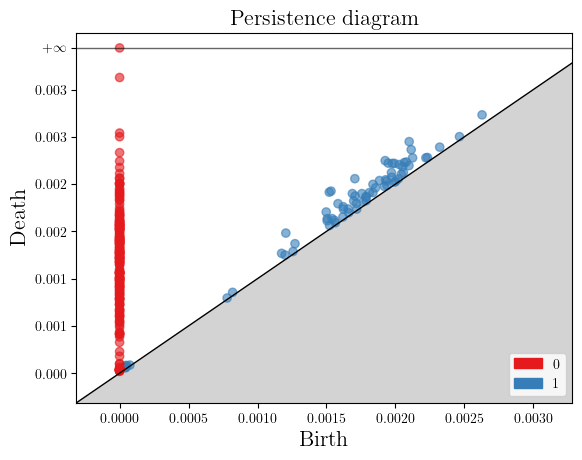

In [5]:
gd.plot_persistence_diagram(persistence1)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

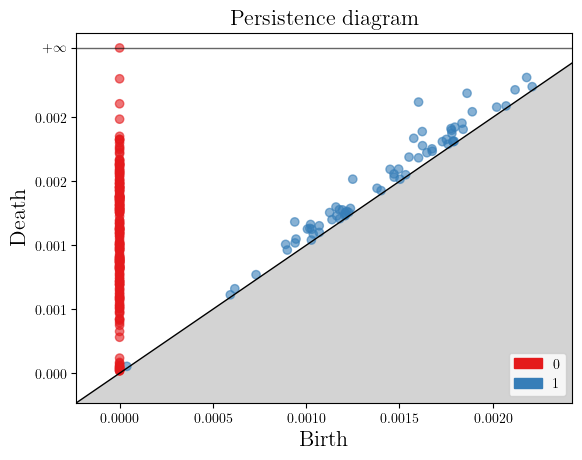

In [6]:
gd.plot_persistence_diagram(persistence2)

In [7]:
# Import necessary libraries
from scipy.spatial.distance import squareform
from gudhi.wasserstein import wasserstein_distance
import numpy as np

# Convert persistence diagrams to numpy arrays
persistence1_np = np.array([list(p[1]) for p in persistence1])
persistence2_np = np.array([list(p[1]) for p in persistence2])

# Extract H0 and H1 diagrams for both images
pd1_H0 = persistence1_np[[p[0] == 0 for p in persistence1]]
pd1_H1 = persistence1_np[[p[0] == 1 for p in persistence1]]
pd2_H0 = persistence2_np[[p[0] == 0 for p in persistence2]]
pd2_H1 = persistence2_np[[p[0] == 1 for p in persistence2]]

# Compute the Wasserstein distance for H0
distance_H0 = wasserstein_distance(pd1_H0, pd2_H0)
print("Wasserstein distance for H0: ", distance_H0)

# Compute the Wasserstein distance for H1
distance_H1 = wasserstein_distance(pd1_H1, pd2_H1)
print("Wasserstein distance for H1: ", distance_H1)


Wasserstein distance for H0:  0.02215538550297085
Wasserstein distance for H1:  0.004052568975649097


### Wasserstein Distances

Below we compute the Wasserstein distances between the original image, and several augmented versions of the image (using rotations and reflections). Although we have cropped the images help prevent interpolation artifacts, the rotated images will still have pixels present that aren't present in the original. One might expect the Wasserstein distances to be much smaller than they are, especially for the images which are just reflections of the original as these should not introduce any interpolation artifacts. However, we see that the persistent homology of an image felected across one of the axes is not the same as the perseistent homology of the original image. We might wish to train the model to preserve the persistent homology of an image that has been augmented in certain ways. 

In [13]:
# Specify the rotations and reflections you want to apply
rotations = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]  # You can change this to whatever rotations you want
reflections = [None, 'x', 'y']  # This will reflect about both axes, and also include the original (rotated) image

# Load the original image
original_image = Image.open("heart.png")
original_image = original_image.convert('RGB')

# Apply all combinations of rotations and reflections
for rotation in rotations:
    for reflection in reflections:
        augmented_image = augment_image_cropped(original_image, rotation, reflection)

        # Get the attention matrix for the augmented image
        attention_matrix = get_attention_matrix(augmented_image, model, tokenizer, layer, head)

        # Compute persistence and simplex trees
        persistence, simplex_tree, distance_matrix = compute_persistence(attention_matrix)

        # Separate points for H_0 and H_1
        pd_H0 = [point[1] for point in persistence if point[0] == 0]
        pd_H1 = [point[1] for point in persistence if point[0] == 1]

        # Separate points for H_0 and H_1
        pd_H0 = np.array([point[1] for point in persistence if point[0] == 0])
        pd_H1 = np.array([point[1] for point in persistence if point[0] == 1])


        # Compute the Wasserstein distance between the original image and the augmented image for H_0 and H_1 separately
        distance_H0 = wasserstein_distance(pd1_H0, pd_H0) if pd_H0.size else None
        distance_H1 = wasserstein_distance(pd1_H1, pd_H1) if pd_H1.size else None


        print(f"Rotation: {rotation}, Reflection: {reflection}, Wasserstein distance H0: {distance_H0}, Wasserstein distance H1: {distance_H1}")


Rotation: -10, Reflection: None, Wasserstein distance H0: 0.05796491051198017, Wasserstein distance H1: 0.004761689265485847
Rotation: -10, Reflection: x, Wasserstein distance H0: 0.054066864825574365, Wasserstein distance H1: 0.003462661055827807
Rotation: -10, Reflection: y, Wasserstein distance H0: 0.059475432352531, Wasserstein distance H1: 0.004692117023345184
Rotation: -7.5, Reflection: None, Wasserstein distance H0: 0.039386180248718615, Wasserstein distance H1: 0.004192966863198056
Rotation: -7.5, Reflection: x, Wasserstein distance H0: 0.02432872584855108, Wasserstein distance H1: 0.003588167434499824
Rotation: -7.5, Reflection: y, Wasserstein distance H0: 0.058229792131043366, Wasserstein distance H1: 0.003704893803795061
Rotation: -5, Reflection: None, Wasserstein distance H0: 0.013669419128232363, Wasserstein distance H1: 0.0035543491687074014
Rotation: -5, Reflection: x, Wasserstein distance H0: 0.011027274678309607, Wasserstein distance H1: 0.0038570793586089145
Rotation:

### Printing with Pictures

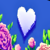

Rotation: -10, Reflection: None, Wasserstein distance H0: 0.05796491051198017, Wasserstein distance H1: 0.004761689265485847


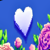

Rotation: -10, Reflection: x, Wasserstein distance H0: 0.054066864825574365, Wasserstein distance H1: 0.003462661055827807


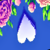

Rotation: -10, Reflection: y, Wasserstein distance H0: 0.059475432352531, Wasserstein distance H1: 0.004692117023345184


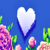

Rotation: -7.5, Reflection: None, Wasserstein distance H0: 0.039386180248718615, Wasserstein distance H1: 0.004192966863198056


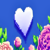

Rotation: -7.5, Reflection: x, Wasserstein distance H0: 0.02432872584855108, Wasserstein distance H1: 0.003588167434499824


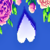

Rotation: -7.5, Reflection: y, Wasserstein distance H0: 0.058229792131043366, Wasserstein distance H1: 0.003704893803795061


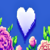

Rotation: -5, Reflection: None, Wasserstein distance H0: 0.013669419128232363, Wasserstein distance H1: 0.0035543491687074014


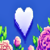

Rotation: -5, Reflection: x, Wasserstein distance H0: 0.011027274678309607, Wasserstein distance H1: 0.0038570793586089145


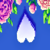

Rotation: -5, Reflection: y, Wasserstein distance H0: 0.05118726950020973, Wasserstein distance H1: 0.003627374472472223


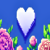

Rotation: -2.5, Reflection: None, Wasserstein distance H0: 0.017082155544712187, Wasserstein distance H1: 0.003870513916249246


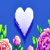

Rotation: -2.5, Reflection: x, Wasserstein distance H0: 0.012245176502054422, Wasserstein distance H1: 0.004647485591583414


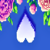

Rotation: -2.5, Reflection: y, Wasserstein distance H0: 0.022240602705402797, Wasserstein distance H1: 0.003815327672582991


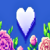

Rotation: 0, Reflection: None, Wasserstein distance H0: 0.01610716016062622, Wasserstein distance H1: 0.003450803729988852


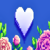

Rotation: 0, Reflection: x, Wasserstein distance H0: 0.009669156819594125, Wasserstein distance H1: 0.00422810910789304


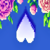

Rotation: 0, Reflection: y, Wasserstein distance H0: 0.022746521652371246, Wasserstein distance H1: 0.0033212682250306565


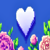

Rotation: 2.5, Reflection: None, Wasserstein distance H0: 0.0217147652905515, Wasserstein distance H1: 0.0040787324966796235


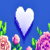

Rotation: 2.5, Reflection: x, Wasserstein distance H0: 0.027642824754765524, Wasserstein distance H1: 0.003372405332954105


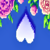

Rotation: 2.5, Reflection: y, Wasserstein distance H0: 0.03755384364072182, Wasserstein distance H1: 0.0035893416441555425


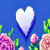

Rotation: 5, Reflection: None, Wasserstein distance H0: 0.030683587737692038, Wasserstein distance H1: 0.00354334944535851


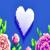

Rotation: 5, Reflection: x, Wasserstein distance H0: 0.029136551458330502, Wasserstein distance H1: 0.0031575530465137915


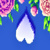

Rotation: 5, Reflection: y, Wasserstein distance H0: 0.04080710211216907, Wasserstein distance H1: 0.0034451954881287586


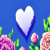

Rotation: 7.5, Reflection: None, Wasserstein distance H0: 0.04037378822705926, Wasserstein distance H1: 0.0040851768895545535


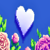

Rotation: 7.5, Reflection: x, Wasserstein distance H0: 0.02664133657447218, Wasserstein distance H1: 0.003722195865715026


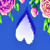

Rotation: 7.5, Reflection: y, Wasserstein distance H0: 0.0472987313807415, Wasserstein distance H1: 0.003600362572830908


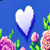

Rotation: 10, Reflection: None, Wasserstein distance H0: 0.05269337579979631, Wasserstein distance H1: 0.003916496536446544


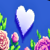

Rotation: 10, Reflection: x, Wasserstein distance H0: 0.05147703717454009, Wasserstein distance H1: 0.003949959908977313


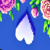

Rotation: 10, Reflection: y, Wasserstein distance H0: 0.0699106973333147, Wasserstein distance H1: 0.0048340999174692435


In [14]:
from IPython.display import display

# Specify the rotations and reflections you want to apply
rotations = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]  # You can change this to whatever rotations you want
reflections = [None, 'x', 'y']  # This will reflect about both axes, and also include the original (rotated) image

# Load the original image
original_image = Image.open("heart.png")
original_image = original_image.convert('RGB')

# Apply all combinations of rotations and reflections
for rotation in rotations:
    for reflection in reflections:
        augmented_image = augment_image_cropped(original_image, rotation, reflection)
        display(augmented_image.resize((50,50)))  # Resize and display the image

        # Get the attention matrix for the augmented image
        attention_matrix = get_attention_matrix(augmented_image, model, tokenizer, layer, head)

        # Compute persistence and simplex trees
        persistence, simplex_tree, distance_matrix = compute_persistence(attention_matrix)

        # Separate the persistence diagrams for H_0 and H_1
        pd_H0 = np.array([point[1] for point in persistence if point[0] == 0])
        pd_H1 = np.array([point[1] for point in persistence if point[0] == 1])

        # Compute the Wasserstein distance between the original image and the augmented image for H_0 and H_1 separately
        distance_H0 = wasserstein_distance(pd1_H0, pd_H0) if pd_H0.size else None
        distance_H1 = wasserstein_distance(pd1_H1, pd_H1) if pd_H1.size else None

        print(f"Rotation: {rotation}, Reflection: {reflection}, Wasserstein distance H0: {distance_H0}, Wasserstein distance H1: {distance_H1}")


### Printing with Pictures and Attention Maps

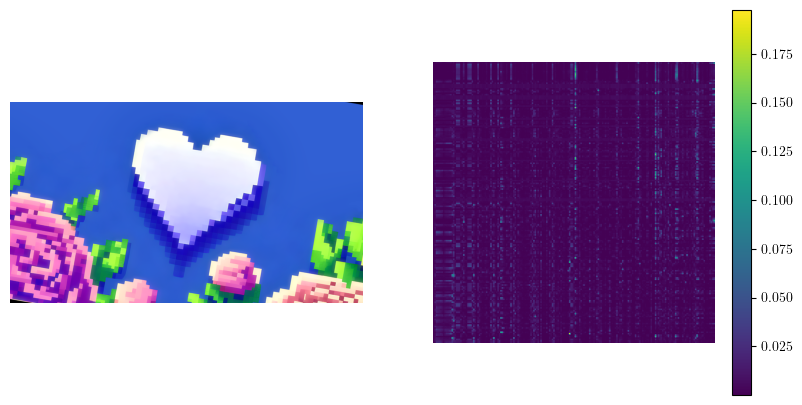

Rotation: -10, Reflection: None, Wasserstein distance H0: 0.05796491051198017, Wasserstein distance H1: 0.004761689265485847


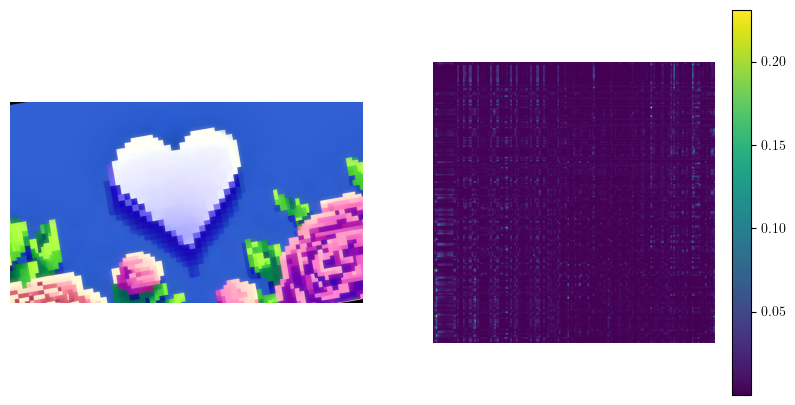

Rotation: -10, Reflection: x, Wasserstein distance H0: 0.054066864825574365, Wasserstein distance H1: 0.003462661055827807


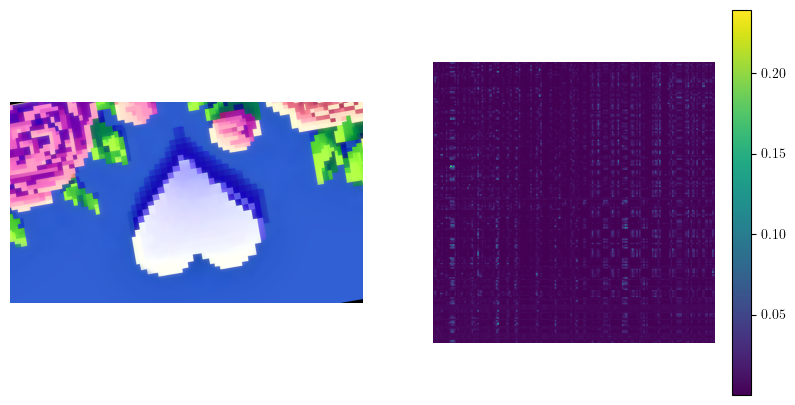

Rotation: -10, Reflection: y, Wasserstein distance H0: 0.059475432352531, Wasserstein distance H1: 0.004692117023345184


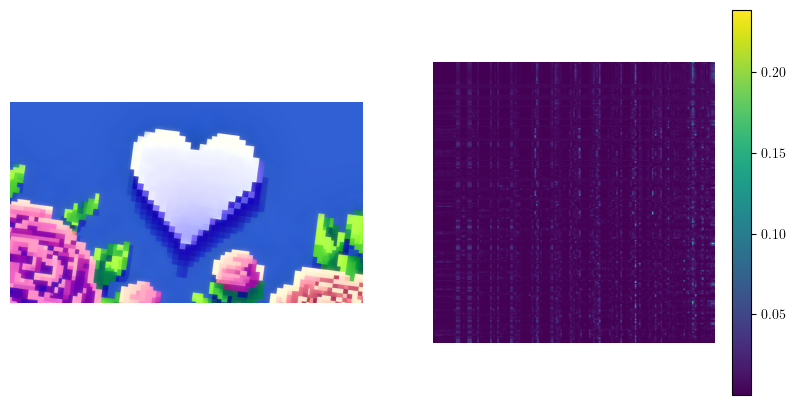

Rotation: -7.5, Reflection: None, Wasserstein distance H0: 0.039386180248718615, Wasserstein distance H1: 0.004192966863198056


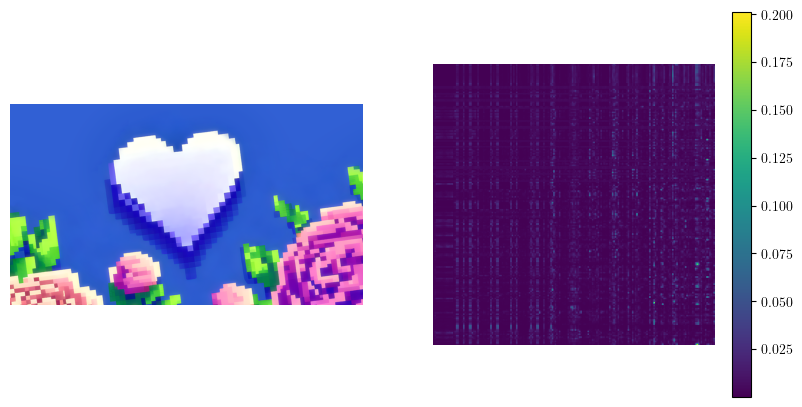

Rotation: -7.5, Reflection: x, Wasserstein distance H0: 0.02432872584855108, Wasserstein distance H1: 0.003588167434499824


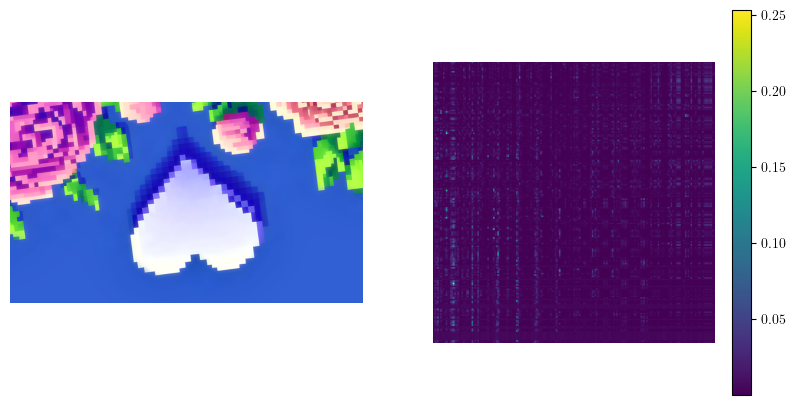

Rotation: -7.5, Reflection: y, Wasserstein distance H0: 0.058229792131043366, Wasserstein distance H1: 0.003704893803795061


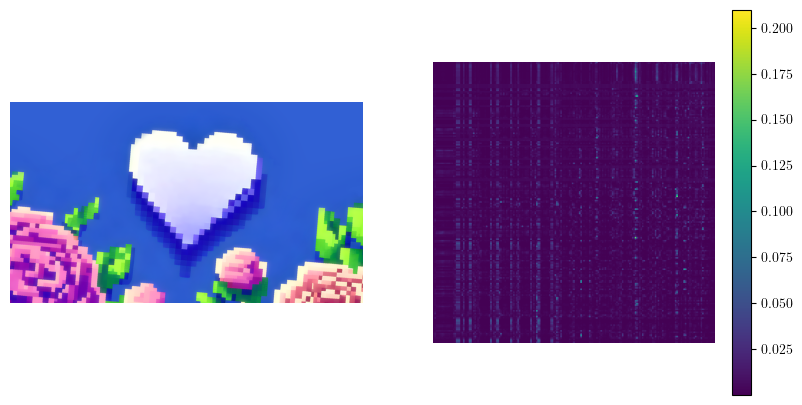

Rotation: -5, Reflection: None, Wasserstein distance H0: 0.013669419128232363, Wasserstein distance H1: 0.0035543491687074014


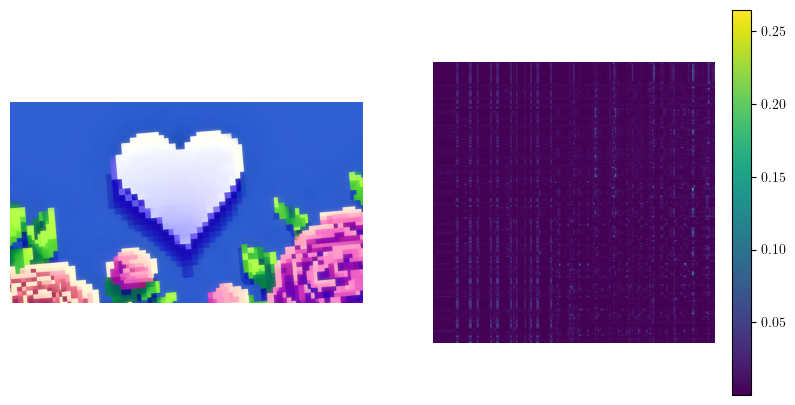

Rotation: -5, Reflection: x, Wasserstein distance H0: 0.011027274678309607, Wasserstein distance H1: 0.0038570793586089145


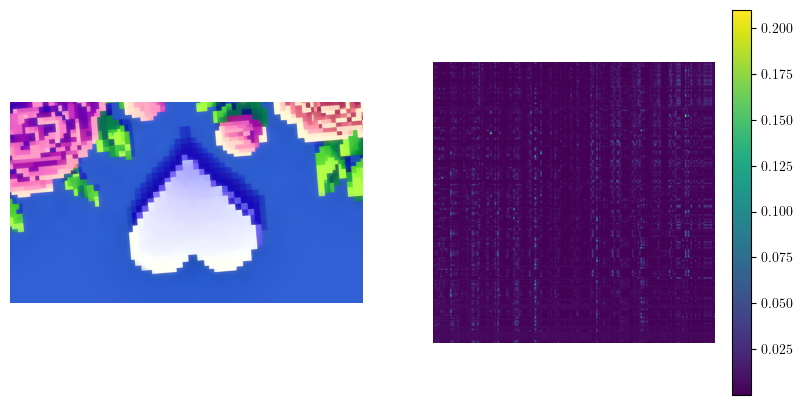

Rotation: -5, Reflection: y, Wasserstein distance H0: 0.05118726950020973, Wasserstein distance H1: 0.003627374472472223


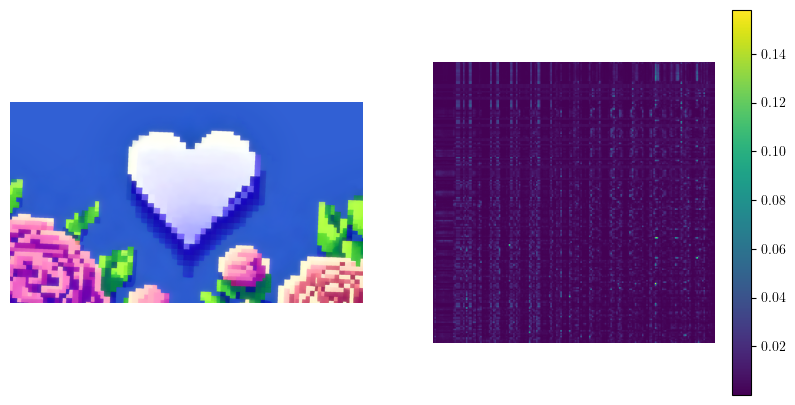

Rotation: -2.5, Reflection: None, Wasserstein distance H0: 0.017082155544712187, Wasserstein distance H1: 0.003870513916249246


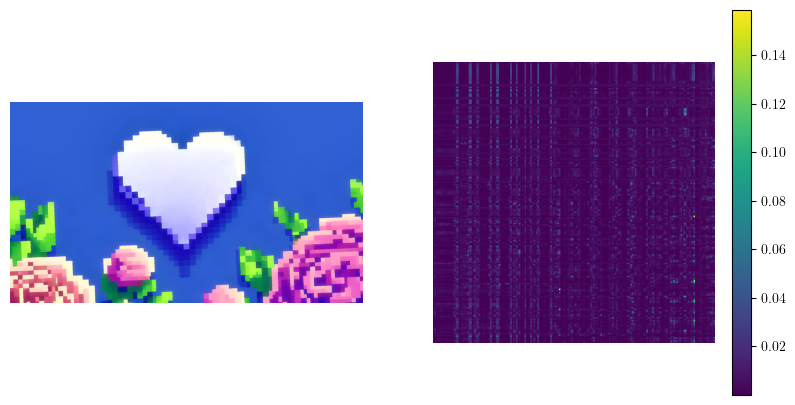

Rotation: -2.5, Reflection: x, Wasserstein distance H0: 0.012245176502054422, Wasserstein distance H1: 0.004647485591583414


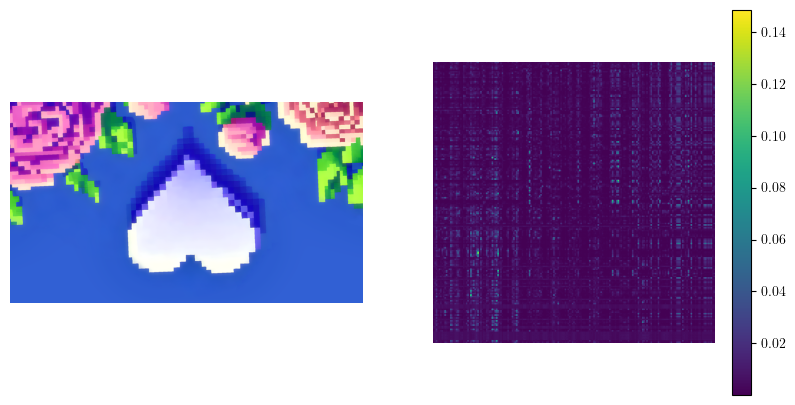

Rotation: -2.5, Reflection: y, Wasserstein distance H0: 0.022240602705402797, Wasserstein distance H1: 0.003815327672582991


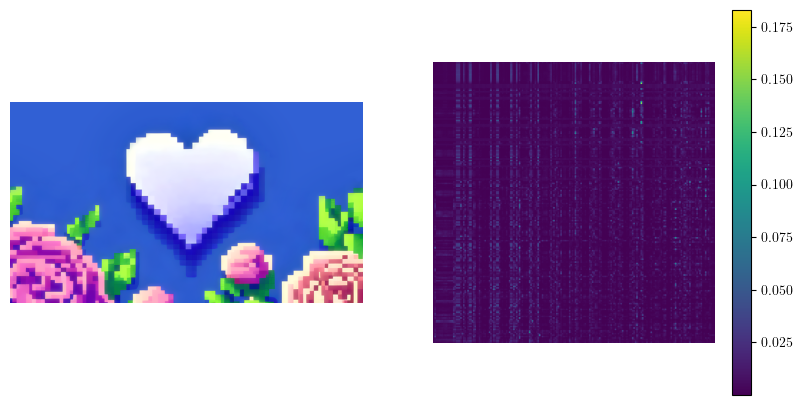

Rotation: 0, Reflection: None, Wasserstein distance H0: 0.01610716016062622, Wasserstein distance H1: 0.003450803729988852


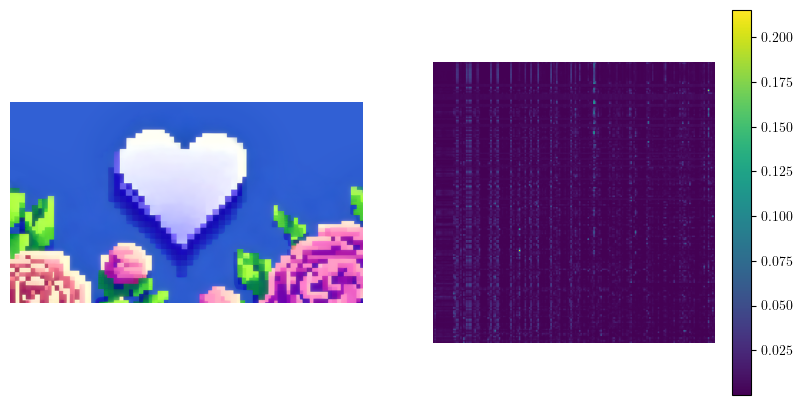

Rotation: 0, Reflection: x, Wasserstein distance H0: 0.009669156819594125, Wasserstein distance H1: 0.00422810910789304


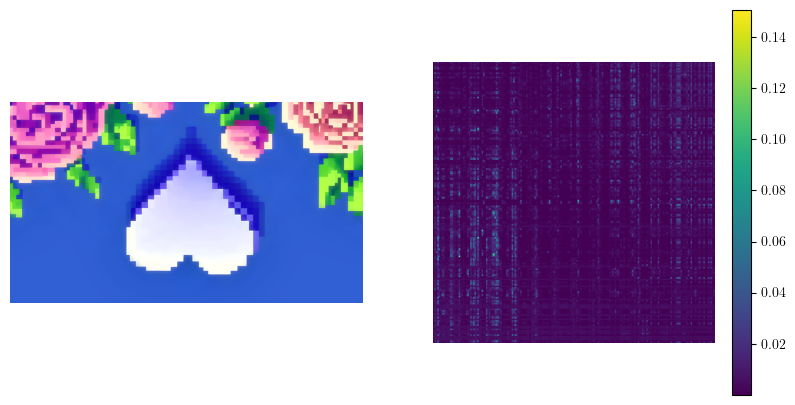

Rotation: 0, Reflection: y, Wasserstein distance H0: 0.022746521652371246, Wasserstein distance H1: 0.0033212682250306565


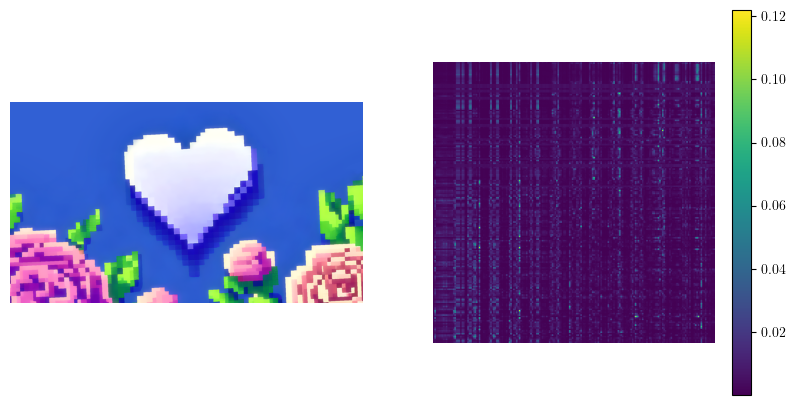

Rotation: 2.5, Reflection: None, Wasserstein distance H0: 0.0217147652905515, Wasserstein distance H1: 0.0040787324966796235


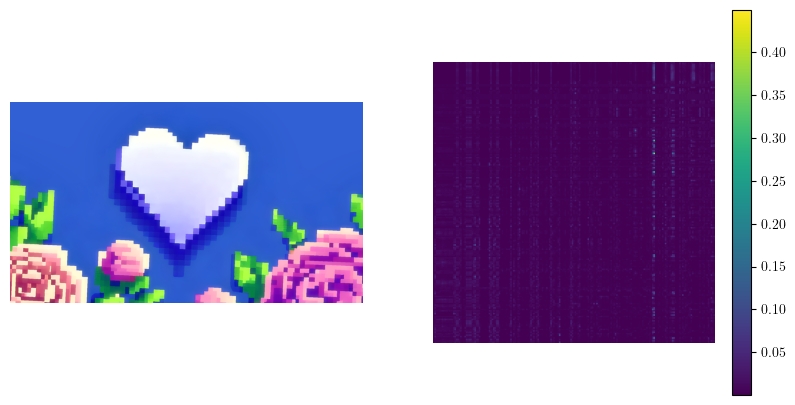

Rotation: 2.5, Reflection: x, Wasserstein distance H0: 0.027642824754765524, Wasserstein distance H1: 0.003372405332954105


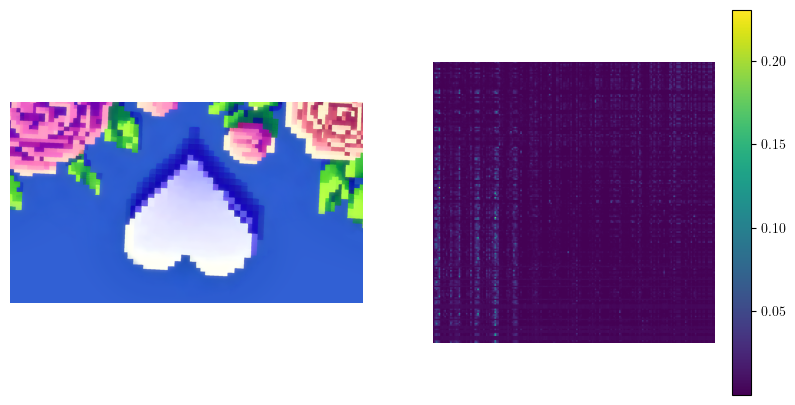

Rotation: 2.5, Reflection: y, Wasserstein distance H0: 0.03755384364072182, Wasserstein distance H1: 0.0035893416441555425


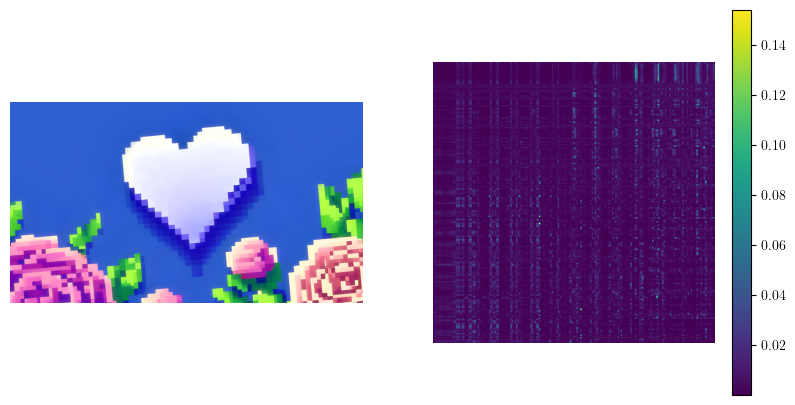

Rotation: 5, Reflection: None, Wasserstein distance H0: 0.030683587737692038, Wasserstein distance H1: 0.00354334944535851


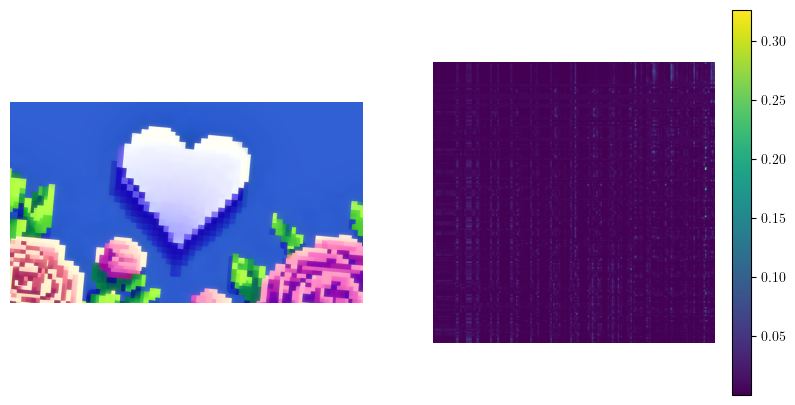

Rotation: 5, Reflection: x, Wasserstein distance H0: 0.029136551458330502, Wasserstein distance H1: 0.0031575530465137915


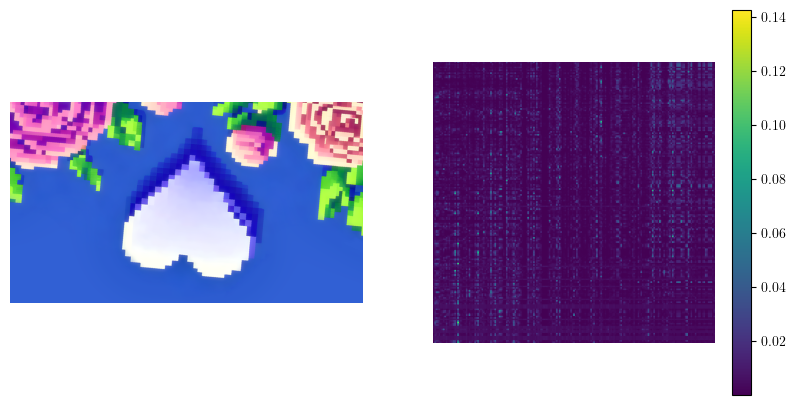

Rotation: 5, Reflection: y, Wasserstein distance H0: 0.04080710211216907, Wasserstein distance H1: 0.0034451954881287586


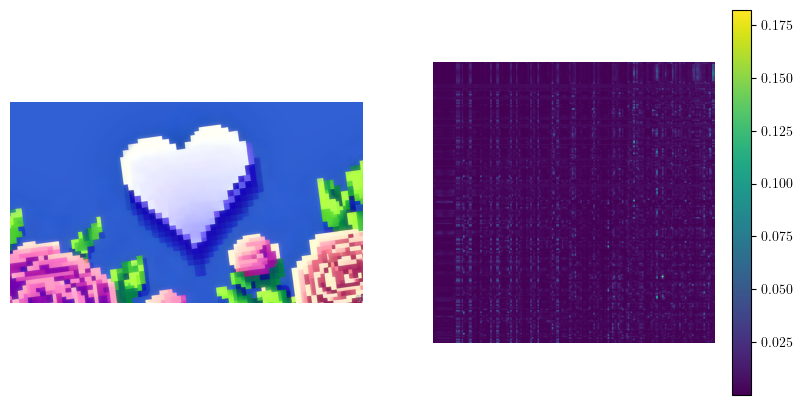

Rotation: 7.5, Reflection: None, Wasserstein distance H0: 0.04037378822705926, Wasserstein distance H1: 0.0040851768895545535


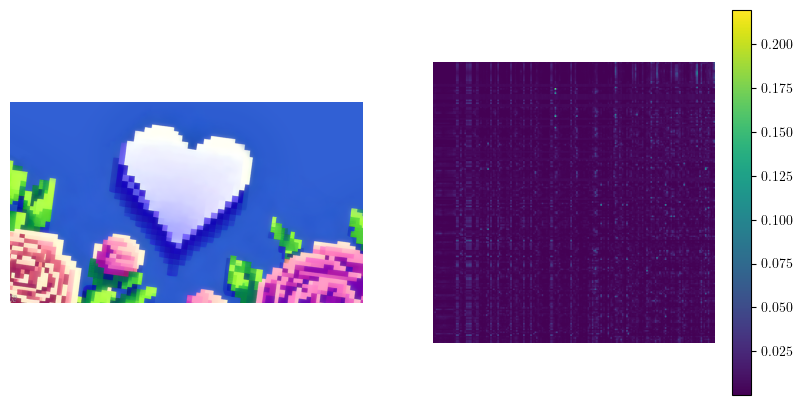

Rotation: 7.5, Reflection: x, Wasserstein distance H0: 0.02664133657447218, Wasserstein distance H1: 0.003722195865715026


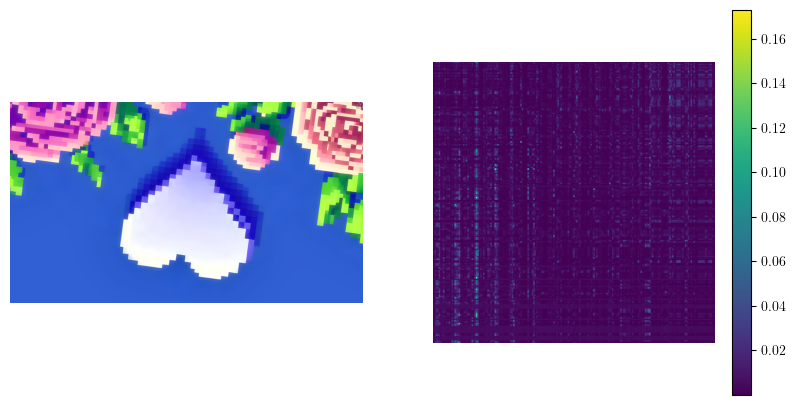

Rotation: 7.5, Reflection: y, Wasserstein distance H0: 0.0472987313807415, Wasserstein distance H1: 0.003600362572830908


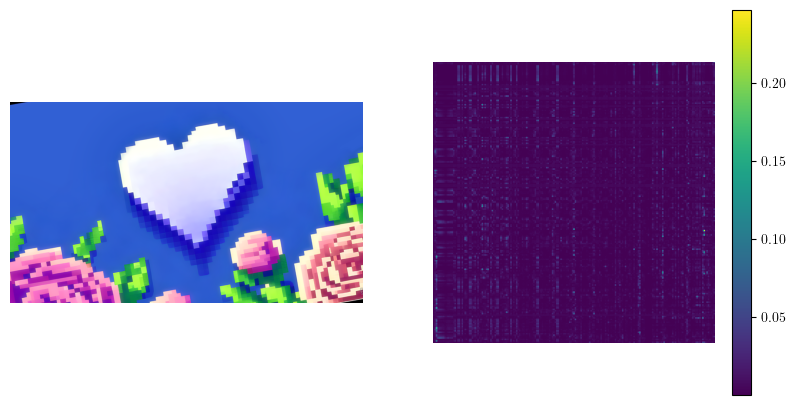

Rotation: 10, Reflection: None, Wasserstein distance H0: 0.05269337579979631, Wasserstein distance H1: 0.003916496536446544


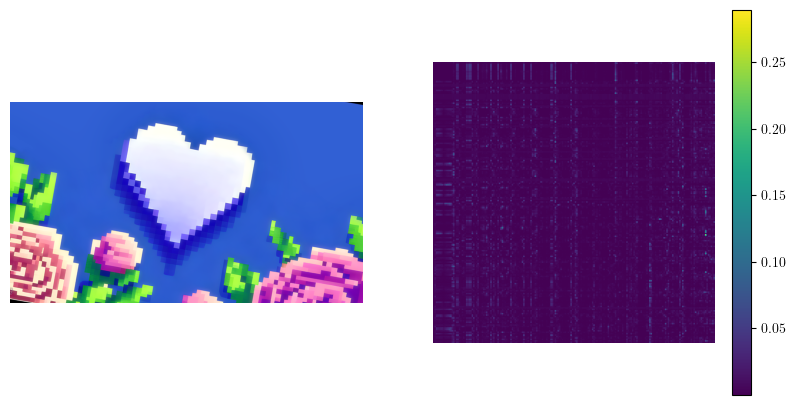

Rotation: 10, Reflection: x, Wasserstein distance H0: 0.05147703717454009, Wasserstein distance H1: 0.003949959908977313


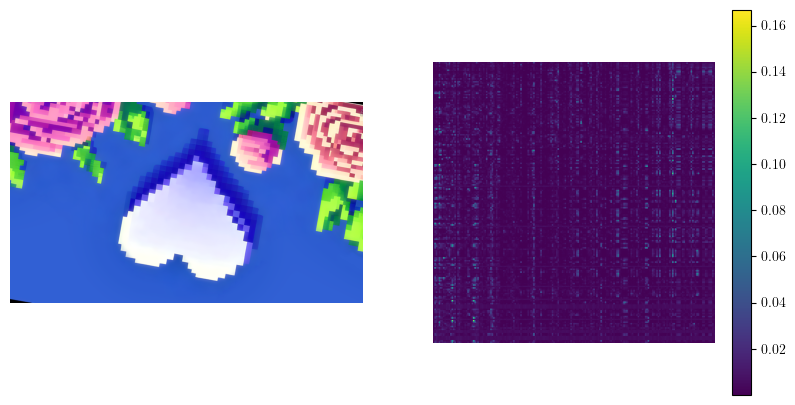

Rotation: 10, Reflection: y, Wasserstein distance H0: 0.0699106973333147, Wasserstein distance H1: 0.0048340999174692435


In [15]:
import matplotlib.pyplot as plt

# Specify the rotations and reflections you want to apply
rotations = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]  # You can change this to whatever rotations you want
reflections = [None, 'x', 'y']  # This will reflect about both axes, and also include the original (rotated) image

# Load the original image
original_image = Image.open("heart.png")
original_image = original_image.convert('RGB')

# Apply all combinations of rotations and reflections
for rotation in rotations:
    for reflection in reflections:
        augmented_image = augment_image_cropped(original_image, rotation, reflection)
        attention_matrix = get_attention_matrix(augmented_image, model, tokenizer, layer, head)

        # Compute persistence and simplex trees
        persistence, simplex_tree, distance_matrix = compute_persistence(attention_matrix)

        # Separate the persistence diagrams for H_0 and H_1
        pd_H0 = np.array([point[1] for point in persistence if point[0] == 0])
        pd_H1 = np.array([point[1] for point in persistence if point[0] == 1])

        # Compute the Wasserstein distance between the original image and the augmented image for H_0 and H_1 separately
        distance_H0 = wasserstein_distance(pd1_H0, pd_H0) if pd_H0.size else None
        distance_H1 = wasserstein_distance(pd1_H1, pd_H1) if pd_H1.size else None

        # Create a subplot for the image and the attention map
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display the image
        axs[0].imshow(np.asarray(augmented_image))
        axs[0].axis('off')

        # Display the attention map
        im = axs[1].imshow(attention_matrix)
        plt.colorbar(im, ax=axs[1])
        axs[1].axis('off')

        plt.show()

        print(f"Rotation: {rotation}, Reflection: {reflection}, Wasserstein distance H0: {distance_H0}, Wasserstein distance H1: {distance_H1}")


## Computing the Fréchet Mean Diagram

In [16]:
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import numpy as np

# List to store the persistence diagrams with dimension
persistence_diagrams = []

# Apply all combinations of rotations and reflections
for rotation in rotations:
    for reflection in reflections:
        augmented_image = augment_image_cropped(original_image, rotation, reflection)
        attention_matrix = get_attention_matrix(augmented_image, model, tokenizer, layer, head)
        persistence, simplex_tree, distance_matrix = compute_persistence(attention_matrix)
        pd = np.array([(point[0], point[1][0], point[1][1]) for point in persistence])  # Include dimension
        persistence_diagrams.append(pd)

# Separate persistence diagrams by dimension and remove infinite values
finite_persistence_diagrams_H0 = []
finite_persistence_diagrams_H1 = []
for pd in persistence_diagrams:
    finite_pd_H0 = pd[(pd[:,0] == 0) & ~np.isinf(pd[:,1:]).any(axis=1)]
    finite_pd_H1 = pd[(pd[:,0] == 1) & ~np.isinf(pd[:,1:]).any(axis=1)]
    finite_persistence_diagrams_H0.append(finite_pd_H0[:, 1:])  # Exclude dimension
    finite_persistence_diagrams_H1.append(finite_pd_H1[:, 1:])  # Exclude dimension

# Check persistence diagrams again and compute the barycenters
for i, (pd_H0, pd_H1) in enumerate(zip(finite_persistence_diagrams_H0, finite_persistence_diagrams_H1)):
    for j, pd in enumerate([pd_H0, pd_H1]):
        homology = "H0" if j == 0 else "H1"
        if pd is None:
            print(f"Diagram at index {i} for {homology} is None.")
        elif pd.shape[1] != 2:
            print(f"Diagram at index {i} for {homology} does not have the correct shape. Expected (?, 2) but got {pd.shape}.")
        elif np.isnan(pd).any():
            print(f"Diagram at index {i} for {homology} contains NaN values.")
        elif np.isinf(pd).any():
            print(f"Diagram at index {i} for {homology} contains infinite values.")
        else:
            print(f"Diagram at index {i} for {homology} seems okay.")

# Computing the barycenters
barycenter_H0 = lagrangian_barycenter(finite_persistence_diagrams_H0)
barycenter_H1 = lagrangian_barycenter(finite_persistence_diagrams_H1)

# Print the barycenters
print("Barycenter for H0: ", barycenter_H0)
print("Barycenter for H1: ", barycenter_H1)


Diagram at index 0 for H0 seems okay.
Diagram at index 0 for H1 seems okay.
Diagram at index 1 for H0 seems okay.
Diagram at index 1 for H1 seems okay.
Diagram at index 2 for H0 seems okay.
Diagram at index 2 for H1 seems okay.
Diagram at index 3 for H0 seems okay.
Diagram at index 3 for H1 seems okay.
Diagram at index 4 for H0 seems okay.
Diagram at index 4 for H1 seems okay.
Diagram at index 5 for H0 seems okay.
Diagram at index 5 for H1 seems okay.
Diagram at index 6 for H0 seems okay.
Diagram at index 6 for H1 seems okay.
Diagram at index 7 for H0 seems okay.
Diagram at index 7 for H1 seems okay.
Diagram at index 8 for H0 seems okay.
Diagram at index 8 for H1 seems okay.
Diagram at index 9 for H0 seems okay.
Diagram at index 9 for H1 seems okay.
Diagram at index 10 for H0 seems okay.
Diagram at index 10 for H1 seems okay.
Diagram at index 11 for H0 seems okay.
Diagram at index 11 for H1 seems okay.
Diagram at index 12 for H0 seems okay.
Diagram at index 12 for H1 seems okay.
Diagra

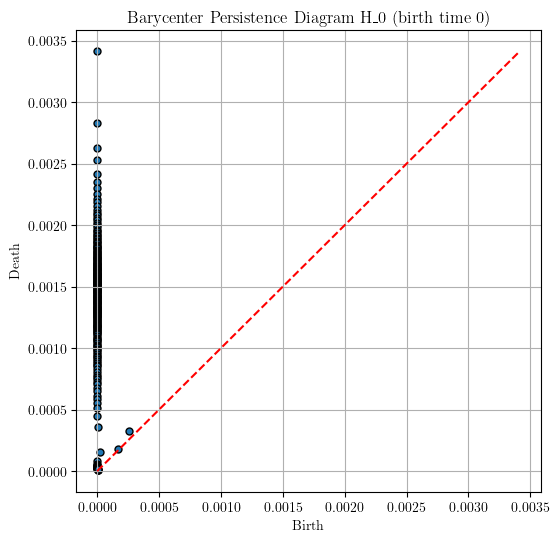

In [17]:
import matplotlib.pyplot as plt

def plot_persistence_diagram(pd, title=None):
    """Plot a persistence diagram."""
    birth = pd[:, 0]
    death = pd[:, 1]

    plt.figure(figsize=(6,6))
    plt.scatter(birth, death, s=25, edgecolor='k')
    plt.plot([np.min(birth), np.max(death)], [np.min(birth), np.max(death)], 'r--')  # diagonal line
    plt.xlabel("Birth")
    plt.ylabel("Death")
    if title:
        plt.title(title)
    plt.grid(True)
    plt.show()

# Plot the filtered barycenter
plot_persistence_diagram(barycenter_H0, title="Barycenter Persistence Diagram H_0 (birth time 0)")


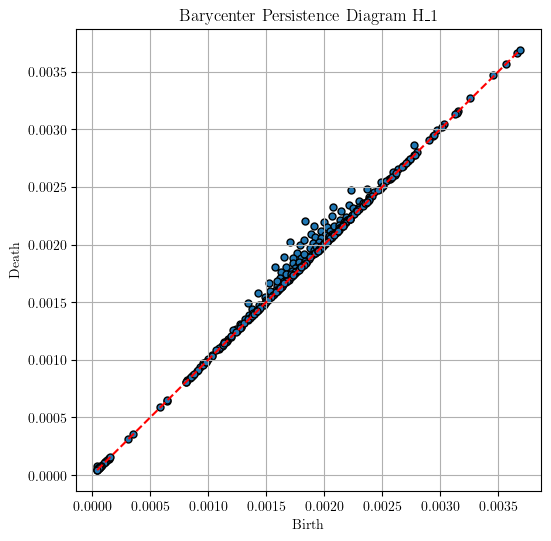

In [18]:
# Plot the barycenter
plot_persistence_diagram(barycenter_H1, title="Barycenter Persistence Diagram H_1")

In [19]:
# Load pre-trained visual transformer model and tokenizer
tokenizer = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Image inputs
image1 = Image.open("heart.png")
image1 = image1.convert('RGB')

image2 = Image.open("platonic_metatron.jpg")
image2 = image2.convert('RGB')


# Choose a layer and head
layer = 11
head = 2

# Get attention matrices
attention_matrix1 = get_attention_matrix(image1, model, tokenizer, layer, head)
attention_matrix2 = get_attention_matrix(image2, model, tokenizer, layer, head)

# Compute persistence and simplex trees
persistence1, simplex_tree1, distance_matrix1 = compute_persistence(attention_matrix1)
persistence2, simplex_tree2, distance_matrix2 = compute_persistence(attention_matrix2)

# Convert persistence diagrams to numpy arrays
persistence1_np = np.array([list(p[1]) for p in persistence1])
persistence2_np = np.array([list(p[1]) for p in persistence2])

# Extract H0 and H1 diagrams for both images
original_pd_H0_1 = persistence1_np[[p[0] == 0 for p in persistence1]]
original_pd_H1_1 = persistence1_np[[p[0] == 1 for p in persistence1]]

original_pd_H0_2 = persistence2_np[[p[0] == 0 for p in persistence2]]
original_pd_H1_2 = persistence2_np[[p[0] == 1 for p in persistence2]]


/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at goo

In [20]:
from gudhi.wasserstein import wasserstein_distance

# Filter out points with infinite death times from the original H0 persistence diagram
finite_original_pd_H0_1 = original_pd_H0_1[np.isfinite(original_pd_H0_1[:, 1])]

# Compute and print the Wasserstein distance for H0 for the first image
distance_H0_1 = wasserstein_distance(barycenter_H0, finite_original_pd_H0_1)
print("Wasserstein distance for H0 for the first image: ", distance_H0_1)

# Compute and print the Wasserstein distance for H1 for the first image
distance_H1_1 = wasserstein_distance(barycenter_H1, original_pd_H1_1)
print("Wasserstein distance for H1 for the first image: ", distance_H1_1)

# Filter out points with infinite death times from the original H0 persistence diagram
finite_original_pd_H0_2 = original_pd_H0_2[np.isfinite(original_pd_H0_2[:, 1])]

# Compute and print the Wasserstein distance for H0 for the second image
distance_H0_2 = wasserstein_distance(barycenter_H0, finite_original_pd_H0_2)
print("Wasserstein distance for H0 for the second image: ", distance_H0_2)

# Compute and print the Wasserstein distance for H1 for the second image
distance_H1_2 = wasserstein_distance(barycenter_H1, original_pd_H1_2)
print("Wasserstein distance for H1 for the second image: ", distance_H1_2)


Wasserstein distance for H0 for the first image:  0.03317197451296715
Wasserstein distance for H1 for the first image:  0.0033110759769546085
Wasserstein distance for H0 for the second image:  0.05361631459973923
Wasserstein distance for H1 for the second image:  0.004298659432769217


Recall the distances between the original `image1` and `image2` persistence diagrams was:

- Wasserstein distance for $H_0:  0.02215538550297085$

- Wasserstein distance for $H_1:  0.004052568975649097$

So, computing the Fréchet mean diagram of the agmented versions of the image is actually helpful, as we see that the distances between the persistence diagram for `image2` and the Fréchet mean is now larger than the distance between the `image1` persistence diagram and the Fréchet mean diagram. Now, we look at some statistices for all of the augmented images' persistence diagrams and their distances to the Fréchet mean diagram to find outliers, and determine if the `image2` persistenc diagram is one of them. 

In [21]:
from scipy.stats import iqr
from scipy import stats

# Store the persistence diagrams
persistence_diagrams_H0 = []
persistence_diagrams_H1 = []

# Store Wasserstein distances
wasserstein_distances_H0 = []
wasserstein_distances_H1 = []

# Compute persistence diagrams and Wasserstein distances
for rotation in rotations:
    for reflection in reflections:
        augmented_image = augment_image_cropped(original_image, rotation, reflection)
        attention_matrix = get_attention_matrix(augmented_image, model, tokenizer, layer, head)
        persistence, simplex_tree, distance_matrix = compute_persistence(attention_matrix)
        
        pd = np.array([(point[0], point[1][0], point[1][1]) for point in persistence])  # Include dimension

        finite_pd_H0 = pd[(pd[:,0] == 0) & ~np.isinf(pd[:,1:]).any(axis=1)]
        finite_pd_H1 = pd[(pd[:,0] == 1) & ~np.isinf(pd[:,1:]).any(axis=1)]
        
        finite_pd_H0 = finite_pd_H0[:, 1:]  # Exclude dimension
        finite_pd_H1 = finite_pd_H1[:, 1:]  # Exclude dimension

        persistence_diagrams_H0.append(finite_pd_H0)
        persistence_diagrams_H1.append(finite_pd_H1)

        wasserstein_distances_H0.append(wasserstein_distance(barycenter_H0, finite_pd_H0))
        wasserstein_distances_H1.append(wasserstein_distance(barycenter_H1, finite_pd_H1))



In [22]:
# Compute statistics for H0
print("\nH0 Wasserstein Distances Statistics")
print("Min: ", np.min(wasserstein_distances_H0))
print("Max: ", np.max(wasserstein_distances_H0))
print("Mean: ", np.mean(wasserstein_distances_H0))
print("Median: ", np.median(wasserstein_distances_H0))
print("Standard Deviation: ", np.std(wasserstein_distances_H0))
print("1st Quantile: ", np.percentile(wasserstein_distances_H0, 25))
print("3rd Quantile: ", np.percentile(wasserstein_distances_H0, 75))
print("Interquartile Range: ", iqr(wasserstein_distances_H0))
print("Outliers: ", [wd for wd in wasserstein_distances_H0 if not (np.percentile(wasserstein_distances_H0, 25) - 1.5*iqr(wasserstein_distances_H0) <= wd <= np.percentile(wasserstein_distances_H0, 75) + 1.5*iqr(wasserstein_distances_H0))])

# Compute statistics for H1
print("\nH1 Wasserstein Distances Statistics")
print("Min: ", np.min(wasserstein_distances_H1))
print("Max: ", np.max(wasserstein_distances_H1))
print("Mean: ", np.mean(wasserstein_distances_H1))
print("Median: ", np.median(wasserstein_distances_H1))
print("Standard Deviation: ", np.std(wasserstein_distances_H1))
print("1st Quantile: ", np.percentile(wasserstein_distances_H1, 25))
print("3rd Quantile: ", np.percentile(wasserstein_distances_H1, 75))
print("Interquartile Range: ", iqr(wasserstein_distances_H1))
print("Outliers: ", [wd for wd in wasserstein_distances_H1 if not (np.percentile(wasserstein_distances_H1, 25) - 1.5*iqr(wasserstein_distances_H1) <= wd <= np.percentile(wasserstein_distances_H1, 75) + 1.5*iqr(wasserstein_distances_H1))])



H0 Wasserstein Distances Statistics
Min:  0.006915706767515394
Max:  0.03926467575262221
Mean:  0.01951719568900965
Median:  0.02025245460151246
Standard Deviation:  0.00790890295003523
1st Quantile:  0.012371845541304875
3rd Quantile:  0.025347868032198212
Interquartile Range:  0.012976022490893337
Outliers:  []

H1 Wasserstein Distances Statistics
Min:  0.0030860131957559838
Max:  0.004821356983333155
Mean:  0.003767977956841425
Median:  0.003674668362649053
Standard Deviation:  0.0004614809320221351
1st Quantile:  0.00346137802446014
3rd Quantile:  0.003939708457409386
Interquartile Range:  0.0004783304329492458
Outliers:  [0.004821356983333155, 0.004778553218918218]


Interestingly, we see outliers among the transformed images. If the model is trained to preserve persistent homology of transformed images, this likely would not happen, and the Wasserstein distances would likely be much smaller. 

In [23]:
# First, compute the Wasserstein distance between the persistence diagram for image2 and the barycenter diagram

# Filter out points with infinite death times from the original H0 persistence diagram
finite_original_pd_H0_2 = original_pd_H0_2[np.isfinite(original_pd_H0_2[:, 1])]

# Compute and print the Wasserstein distance for H0 for the second image
distance_H0_2 = wasserstein_distance(barycenter_H0, finite_original_pd_H0_2)
print("Wasserstein distance for H0 for the second image: ", distance_H0_2)

# Compute and print the Wasserstein distance for H1 for the second image
distance_H1_2 = wasserstein_distance(barycenter_H1, original_pd_H1_2)
print("Wasserstein distance for H1 for the second image: ", distance_H1_2)

# Now, check if these distances are outliers in the distribution of distances for the augmented images

# For H0
lower_bound_H0 = np.percentile(wasserstein_distances_H0, 25) - 1.5*iqr(wasserstein_distances_H0)
upper_bound_H0 = np.percentile(wasserstein_distances_H0, 75) + 1.5*iqr(wasserstein_distances_H0)
if distance_H0_2 < lower_bound_H0 or distance_H0_2 > upper_bound_H0:
    print("The Wasserstein distance for H0 for the second image is an outlier.")
else:
    print("The Wasserstein distance for H0 for the second image is not an outlier.")

# For H1
lower_bound_H1 = np.percentile(wasserstein_distances_H1, 25) - 1.5*iqr(wasserstein_distances_H1)
upper_bound_H1 = np.percentile(wasserstein_distances_H1, 75) + 1.5*iqr(wasserstein_distances_H1)
if distance_H1_2 < lower_bound_H1 or distance_H1_2 > upper_bound_H1:
    print("The Wasserstein distance for H1 for the second image is an outlier.")
else:
    print("The Wasserstein distance for H1 for the second image is not an outlier.")


Wasserstein distance for H0 for the second image:  0.05361631459973923
Wasserstein distance for H1 for the second image:  0.004298659432769217
The Wasserstein distance for H0 for the second image is an outlier.
The Wasserstein distance for H1 for the second image is not an outlier.


Above, we see that in terms of the $H_0$ Fréchet mean persistence diagram, the persistent diagram for `image2` is an outlier, but in terms of the $H_1$ Fréchet mean persistence diagram, the persistent diagram for `image2` is not outlier. We may benefit from a model that has been trained to preserve persistent homology under certain transformations of the input image, which would then give tighter bounds on the Wasserstein distance between the persistent diagram of an augmented image and the original image. This would result in a Fréchet mean diagram that is closer to each of transformed image's persistence diagram, and easier detection of anomalous images that don't have similar persistent homology to our original image. This can then be used for things like image clustering and may improve performance on various downstream tasks. 